In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_prod_mon_Y_DN.csv",encoding="shift-jis",index_col=0)
df["prod_date"]

0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4194    2022-08-31
4195    2022-09-30
4196    2022-10-31
4197    2022-11-30
4198    2022-12-31
Name: prod_date, Length: 4199, dtype: object

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4194    0
4195    0
4196    0
4197    0
4198    0
Name: mon_1, Length: 4199, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_pro_agg"].replace(",","",regex=True,inplace=True)
df["rx_pro_agg"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_pro_agg"].fillna(0,inplace=True)
df["rx_pro_agg"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_pro_agg"]=df["otc_pro_agg"].astype(int)
df["rx_pro_agg"]=df["rx_pro_agg"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(float)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_pro_agg"]>0]
df=df.loc[df["rx_pro_agg"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_pro_agg"]=np.log(df["rx_pro_agg"])
df["log_otc_pro_agg"]=np.log(df["otc_pro_agg"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [5]:
# change to the datetime format
df['prod_date'] = pd.to_datetime(df["prod_date"], format='%Y-%m-%d')
df=df.set_index(["id","prod_date"])
# df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2470 entries, (114, Timestamp('2009-02-28 00:00:00')) to (799, Timestamp('2022-12-31 00:00:00'))
Columns: 128 entries, year to year_trend
dtypes: float64(18), int32(2), int64(80), object(16), uint8(12)
memory usage: 2.2+ MB


(128, 167, 19)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [7]:
before_p=10
after_p=15
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)


+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15


                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
elapsed_m10         -0.1768     0.1503    -1.1764     0.2396     -0.4715      0.1179
elapsed_m9          -0.1767     0.1065    -1.6598     0.0971     -0.3855      0.0321
elapsed_m8          -0.1043     0.1361    -0.7665     0.4434     -0.3713      0.1626
elapsed_m7          -0.1993     0.1585    -1.2576     0.2087     -0.5100      0.1115
elapsed_m6           0.0086     0.1203     0.0714     0.9431     -0.2274      0.2446
elapsed_m5          -0.0248     0.0891    -0.2778     0.7812     -0.1995      0.1500
elapsed_m4           0.1449     0.0969     1.4948     0.1351     -0.0452      0.3349
elapsed_m3           0.0795     0.0929     0.8557     0.3922     -0.1027      0.2618
elapsed_m2           0.2122     0.1181     1.7976     0.0724     

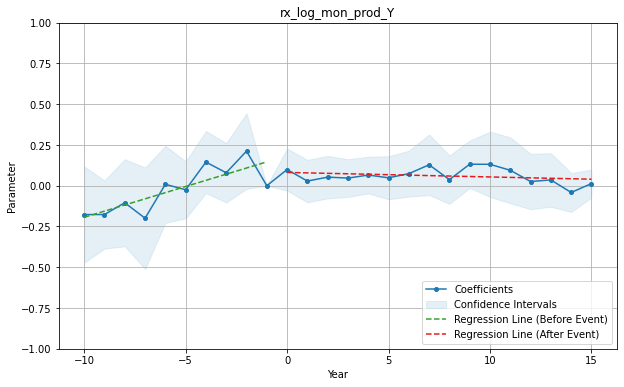

In [8]:
# take log
formula="log_rx_pro_agg ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_prod_Y",title="rx_log_mon_prod_Y",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
elapsed_m10           0.4990     0.2657     1.8783     0.0605     -0.0220      1.0199
elapsed_m9            0.5600     0.2856     1.9609     0.0500   -3.32e-05      1.1200
elapsed_m8            0.4349     0.4191     1.0376     0.2996     -0.3870      1.2568
elapsed_m7            0.1981     0.3107     0.6375     0.5239     -0.4112      0.8073
elapsed_m6           -0.0115     0.2222    -0.0518     0.9587     -0.4473      0.4242
elapsed_m5            0.1781     0.2472     0.7205     0.4713     -0.3066      0.6627
elapsed_m4            0.1624     0.2083     0.7799     0.4355     -0.2460      0.5709
elapsed_m3            0.3625     0.1931     1.8770     0.0607     -0.0162      0.7412
elapsed_m2            0.2515     0.1822     1.3808    

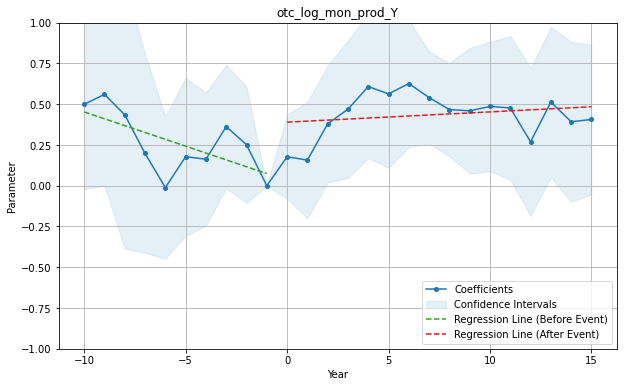

In [9]:
# take log

# till 20
# formula="log_otc_pro_agg ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_pro_agg ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_otc_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_prod_Y",title="otc_log_mon_prod_Y",ylim=(-1,1),plot_type="o-",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

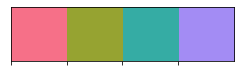

In [10]:
import seaborn as sns

# 視認性の良い4つの色を生成
colors = sns.color_palette('husl', 4)

# カラーマップを表示
sns.palplot(colors)
